In [11]:
import numpy as np
import itertools
import math
import statistics as stat
import matplotlib.pyplot as plt
import pdb
from scipy.optimize import linprog

In [12]:
class MDP:
    def __init__(self, numStates, numActions, p, c, d, alpha, stateDist=None):
        """temp[]
        Reference:
        Args:
            numStates: integer, number of states of the MDP
            numActions: integer, number of actions of the MDP
            p: matrix, numStates-by-numActions-by-numStates probability 
                transition matrix of the MDP
            r: matrix, numStates-by-numActions reward matrixof the MDP
            stateDist: vector, 1-by-numState, the initial probability distribution
                 over the states of the MDP, default is uniform distribution
        Return:
            A MDP object with the specified numStates, numActions, p, r
            and stateDist
        """
        
        self.p = np.asarray(p)
        self.c = c
        self.d = d
        self.alpha = alpha
        
        # The size of p is numStates by numActions by numStates
        # p(s, a, s') denotes the probability to transit to state
        # s' after taking action a at state s.
        # As such, \sum_i p(s, a, i) = 1
        assert self.p.shape == (numStates, numActions, numStates), \
        "The shape of the transition probabiliy matrix is incorrect!"
#         assert self.r.shape == (numStates, numActions), \
#         "The shape of the reward matrix is incorrect!"
        for state in range(numStates):
            for action in range(numActions):
                probSum = 0
                for nextState in range(numStates):
                    probSum += p[state][action][nextState]
                assert probSum == 1, \
                "The sum of probabilities p({}, {}, )".format(state, action) + \
                " over all possible next staes not euqla to 1"
        
        self.numStates = numStates
        self.numActions = numActions
        # The user can customize the prob distribution of states
        # Otherwise, it is set to be uniform by default.
        if stateDist:
            self.stateDist = stateDist
        else:
            self.stateDist = np.ones(self.numStates) / self.numStates
    
    def set_state(self, state=None):
        if state is None:
            self.state = np.random.choice(self.numStates, p=self.stateDist)
        else:
            self.state = state
        return self.state

    def transit(self, action):
        nextState = np.random.choice(self.numStates, p=self.p[self.state, action])
        cost = self.c[self.state, action]
        self.state = nextState
        return nextState, cost

In [13]:
def extended_lp(env, pHat, p_conf, dsa, cost_sa, alpha, mu, timesteps):
    ''', 
    Reference:
        Figure 2 of the paper - Jaksch, Thomas, Ronald Ortner, and Peter Auer. 
        "Near-optimal Regret Bounds for Reinforcement Learning." 
        Journal of Machine Learning Research 11, no. 4 (2010).
    Args:
        PsaHat: vector, MLE estimate for p(.|s, a)
        PsaConfidenceBound: float, the confidence bound of PsaHat
        statesSortByU: vector, states sorted by the descending order of u value
        tolerance: float, the tolerance of the while loop in the inner maximization
    Return:
        Psa: vector, the optimistic transition probabilities p(.|s, a).
        
      zsa = extended_lp(env,pHat, pConfidenceBound, constraint_cost, cost, alpha,numStates, numActions, mu, timesteps, tolerance)

    '''
    
    numStates, numActions = env.numStates, env.numActions

    # Cost matrix for H timesteps
    cvec_Mat = np.zeros((timesteps, numStates**2 * env.numActions))
    
    # p(s'|s,a) + \beta(s,a,s')
    qMat = pHat + p_conf
    
    # p(s'|s,a) - \beta(s,a,s')
    q_primeMat = pHat - p_conf

    # Inquality constraint matrix corresponding to constraint 1
    dvec_Mat = np.zeros((alpha.size, timesteps*numStates**2 * env.numActions))

    for constr_id in range(alpha.size):
      dvec_hsqa = np.zeros((timesteps, numStates**2 * env.numActions))
      for i in range(timesteps):
          # constraintMat is of dimension SxSA for each timestep          
          constraintMat = np.tile(dsa[constr_id,:,:].reshape(1, dsa.shape[1]*dsa.shape[2]), (numStates, 1))          
          dvec_hsqa[i, :] = np.reshape(constraintMat, numStates**2 * numActions, order='F')
      # Update each row of constraint matrix with the vector of dimendion HS2A
      dvec_Mat[constr_id, :] = np.reshape(dvec_hsqa.ravel(), (1, dvec_hsqa.shape[0]*dvec_hsqa.shape[1]))

    # Inequality constraint matrix corresponding to constraint 2
    Ah_eq = np.zeros((timesteps-1, timesteps * numStates**2 * env.numActions))

    id = numStates**2 * numActions
    
    if timesteps == 1:
      a =1
    else:
        for h in range(0, timesteps-1):                    
            Ah_eq[h, h*id: (h+1)*id] = -1
            Ah_eq[h, (h+1)*id: (h+2)*id] = 1

    # Equality constraint matrix corresponding to constraint 3
    A_eq = np.zeros((numStates, timesteps * numStates**2 * env.numActions))
    for s in range(env.numStates):
        A_eq[s, s*(numStates*numActions):(s+1)*(numStates*numActions)] = 1
    
    # Inequality constraint matrix corresponding to constraint 5
    A_ubound = np.zeros((timesteps * numStates**2 * numActions, timesteps * numStates**2 * numActions))
    
    # Inequality constraint matrix corresponding to constraint 6
    A_lbound = np.zeros((timesteps * numStates**2 * numActions, timesteps * numStates**2 * numActions))
            
        
    
    counter = 0
    for i in range(timesteps):
        for j in range(numStates):
            for k in range(numActions):
                for l in range(numStates):               
                    
                    for s_prime in range(-l, -l + numStates):
                        
                        A_ubound[counter, counter + s_prime] = -qMat[i,j,k,l + s_prime]
                        A_lbound[counter, counter + s_prime] = q_primeMat[i,j,k,l + s_prime]
                    # Update diagonal elements
                    A_ubound[counter, counter] = 1-qMat[i,j,k,l]
                    A_lbound[counter, counter] = -1+q_primeMat[i,j,k,l]
                    
                    counter += 1
    

    A_lbound = A_lbound.T
    A_ubound = A_ubound.T

    for h in range(timesteps):
      temp = np.tile(cost_sa.reshape(1, cost_sa.shape[0]*cost_sa.shape[1]), (numStates, 1))
      cvec_Mat[h, :] = np.reshape(temp, numStates**2 * env.numActions, order='F')  

    # Coefficients of linear objective function    
    # cost_vec = cvec_Mat.ravel()    
    
    # Define optimization variables    
    c_final = cvec_Mat.ravel()

    # Equality constraint vector corresponding to constraint 3
    b_eq = np.concatenate((mu, np.zeros(timesteps-1)),axis=0)
    

    temp = np.reshape(np.asarray(alpha), (alpha.size,1))
    # Inquality constraint vector corresponding to constraint 1
    b_ub = np.concatenate((temp, np.zeros((2*numStates**2 * numActions*timesteps, 1))), axis=0)
    
    A_eq_final = np.concatenate((A_eq, Ah_eq), axis=0)
    A_ub_final = np.concatenate((dvec_Mat, A_ubound, A_lbound), axis=0)
    
    res = linprog(c_final, A_eq=A_eq_final, b_eq=b_eq, A_ub=A_ub_final, b_ub=b_ub)
    
    return res.x

In [14]:
def extended_value_iteration(env, timesteps, stateActionCounts, pHat, pConfidenceBound, cost, constraint_cost, alpha):
    '''
    Reference:
        3.1.2 EXTENDED VALUE ITERATION of the paper - 
        Jaksch, Thomas, Ronald Ortner, and Peter Auer. 
        "Near-optimal Regret Bounds for Reinforcement Learning." 
        Journal of Machine Learning Research 11, no. 4 (2010).
    Args:
        numStates: integer, number of states of the MDP
        numActions: integer, number of actions of the MDP
        pHat: matrix, MLE estimates of state-by-action-by-state transition probability matrix
        pConfidenceBound: float, optimistic confidence bounds for pHat
        rHat: matrix, MLE estimates of state-by-action rewards matrix
        rConfidenceBound: float, optimistic confidence bounds for rHat
        epsilon: float, the epsilon of Page 30 of the referenced slides below
            https://www.math.univ-toulouse.fr/~agarivie/sites/default/files/saopaulo1010RL.pdf
        tolerance: float, the tolerance of the while loop in the inner maximization
    Return:
        (pTilde, rTilde) - params that can determine the optimistic MDP Mk
            pTilde: matrix, state-by-action-by-state transition probability matrix of Mk
            rTilde: matrix, state-by-action reward matrix of Mk
        piTilde: vector, optimal policy of Mk, piTilde[i] is the optimal action at state i
    '''
    
    # Initiate state values u_0 in Eq (5) of the paper
    # stateUDiff is the diference of values u u_{i}-u_{i-1}
    # between two iterations
    
    
    zHat = np.random.uniform(0, 1, (numStates, numActions, numStates))
    for i in range(numActions):
        zHat[:, i, :] =(zHat[:, i, :].T/np.sum(zHat[:, i, :], axis = 1)).T
    
    
    # Initialized the state-action-state transition probability matrix pTilde
    # and the optimal policy piTilde for the optimistic MDP
    pTilde = np.zeros((timesteps,numStates, numActions, numStates))
    piTilde = np.zeros((timesteps, numStates), dtype='int')

    pi_vec = np.zeros((timesteps, numStates, numActions))
    
    #Prior distribution
    mu = np.ones(numStates) / numStates
    
    zsa = extended_lp(env, pHat, pConfidenceBound, constraint_cost, cost, alpha, mu, timesteps)

    '''
    Calculate p(s'|s,a) and \pi(a|s)
    TBD: Vectorize code
    '''
    zMat = zsa.reshape(timesteps,numStates, numActions, numStates)
    for h in range(timesteps):
      for s in range(numStates):
        pi_den = np.sum(zMat[h,s,:,:])
        for a in range(numActions):
          sum = np.sum(zMat[h,s,a,:])
          pi_vec[h, s, a] = sum / pi_den
          for y in range(numStates):
            pTilde[h,s,a,y] = zMat[h,s,a,y] / sum

    for h in range(timesteps):
      for s in range(numStates):
        piTilde[h,s] = np.argmax(pi_vec[h,s,:])

    return piTilde, pTilde

In [15]:
def cmdp_algo(env, delta, timesteps, episode_length=5, initialState=None):
    
    numStates, numActions = env.numStates, env.numActions
    t = 1
    
    # Initial state
    state = env.set_state(initialState)
    
    # Model estimates
    stateActionCounts = np.zeros((numStates, numActions))
    stateActionCosts = np.zeros((numStates, numActions))
    stateActionStateCounts = np.zeros((numStates, numActions, numStates))
    
    pHat = np.ones((numStates, numActions, numStates)) / numStates
    pHat = np.repeat(pHat[np.newaxis, :, :, :], timesteps, axis=0) #Dimension HSAS'
   
    
    for k in range(episode_length):
        # Set the start time of episode k, Tk :=t.
        Tk = t
        
        # For all (s,a) in S ×A initialize the state-action counts for episode k, Vk(s,a) := 0##
        Vk = np.zeros((numStates, numActions))
        
        #pConfidenceBound = np.sqrt(np.multiply(pHat, 1-pHat) / np.clip(stateActionCounts, 1.0, None)) + (1 / np.clip(stateActionCounts, 1.0, None))
        # Ensuring dimension of pConfidenceBound is HxSxAxS
        temp = np.clip(stateActionCounts, 1.0, None)
        pConfidenceBound = np.sqrt(np.multiply(pHat, 1-pHat) / np.repeat(temp[:, :, np.newaxis], pHat.shape[3], axis=pHat.shape[3])) + np.repeat((1 / temp)[:, :, np.newaxis], pHat.shape[3], axis=pHat.shape[3])

        
        PIk, Mk = extended_value_iteration(env, timesteps, stateActionCounts, pHat, pConfidenceBound, env.c, env.d, env.alpha)
        
        # Execute the policy
        for h in range(timesteps):
          action = PIk[h, state]
          nextState, cost = env.transit(action)
          yield (t, state, action, nextState, cost)   
          Vk[state, action] += 1
          stateActionCosts[state, action] += cost
          stateActionStateCounts[state, action, nextState] += 1  
          t += 1
          state = nextState  
          action = PIk[state]
            
          
        pHat = Mk

In [16]:
theta = 0.1
numStates = 2
numActions = 2
p = np.array([
    [[1, 0], [.3, .7]],
    [[0.1, 0.9], [.2, .8]]
])
print('Transition matrix shape',p.shape)

c = np.reshape(np.array([[.5, .9], [.3, .6]]), (numStates*numActions,1))
d = np.reshape(np.array([
                         [[.4, .8], [.1, .3]],
                         [[.25, .7], [.15, .8]]
                         ]), (2,numStates*numActions,1))
print(d.shape)
alpha = np.array([0.5, .2])

Transition matrix shape (2, 2, 2)
(2, 4, 1)


In [7]:
experiments = []
numSteps = 400
numRepeats = 20
timesteps = 1
NUM_EPS = 60
for i in range(numRepeats):
    env = MDP(numStates, numActions, p, c, d, alpha)
    transitions = cmdp_algo(env, delta=0.1, timesteps=1, episode_length=NUM_EPS, initialState=0)
    
    curtExp = []
    for j in range(NUM_EPS):
        (t, state, action, nxtState, cost) = transitions.__next__()
        curtExp.append((t, state, action, nxtState, cost))
    experiments.append(curtExp)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [8]:
cumRegrets = np.zeros([numRepeats, numSteps])
perStepRegrets = np.zeros([numRepeats, numSteps])
optimalCost = 0.0

for i in range(numRepeats):
    cumRegret = 0.0
    for j in range(NUM_EPS):
        (t, state, action, nxtState, cost) = experiments[i][j]
        cumRegret += cost - optimalCost
        cumRegrets[i, j] = cumRegret
        perStepRegrets[i, j] = cumRegret / t

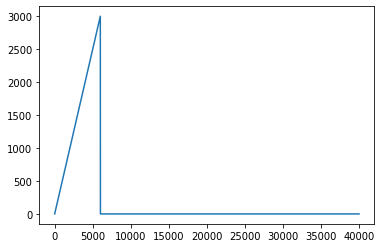

In [9]:
plt.plot(cumRegrets.mean(axis=0))

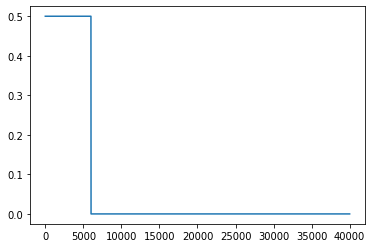

In [10]:
plt.plot(perStepRegrets.mean(axis=0))